# HEOM Tutorial

This tutorial demonstrates how to compute the dynamics of a 2-level quantum system interacting with a bath. The formalism for this is the Hierarchy of Equations of Motion (HEOM).


In [1]:
import cmath
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py import data_read
import libra_py.dynamics.heom.compute as compute
from libra_py import ft


plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

## Unscaled HEOM

Define the system's Hamiltonian, which is stored in the `Ham` variable

In [2]:
Ham = CMATRIX(2,2)
Ham.set(0, 0, 50.0 * units.inv_cm2Ha);    Ham.set(0, 1, 200.0 * units.inv_cm2Ha);
Ham.set(1, 0,200.0 * units.inv_cm2Ha);    Ham.set(1, 1, -50.0 * units.inv_cm2Ha);

Define the initial density matrix describing the quantum system. In this case, we initialize the system to be in the 1-st exctied state (index 1)

In [3]:
rho = CMATRIX(2,2)
rho.set(0, 0, 1.0+0.0j)   

Define the parameters of the bath and the system

Note: 

it works for `do_scale == 0`

it works with both `do_zeroing == 0` and `do_zeroing == 1`

for `do_scale == 1`, it shows something else - there is a decay too, but not as fast


The `truncation_scheme == 3`  or `truncation_scheme == 4` are preferred
The `truncation_scheme == 1` is okay
the `truncation_scheme == 2` doesn't work and it should not!


In [4]:
params = { "KK":0, "LL":10,
           "gamma": 1.0/(0.1 * units.ps2au),
           "eta": 2.0 * 50.0 * units.inv_cm2Ha,
           "temperature": 300.0,
           "el_phon_couplings":initialize_el_phonon_couplings2(2),

           "dt":0.1*units.fs2au, "nsteps":10000, 
           "verbosity":3, "progress_frequency":0.1,

           "truncation_scheme":4, "do_scale":0,
           "adm_tolerance":1e-10, "adm_deriv_tolerance":1e-15,
           "filter_after_steps":1,"do_zeroing":1,
           "num_threads":4,

           "prefix":"out", 
           "hdf5_output_level":0, "txt_output_level":0, "mem_output_level":3,
           "properties_to_save": [ "timestep", "time", "denmat"],
           "use_compression":0, "compression_level":[0,0,0]
         }


To learn more about what each parameter means, look in the docs of the `run_dynamics` function

In [5]:
print(params)

{'KK': 0, 'LL': 10, 'gamma': 0.00024189999999999997, 'eta': 0.0004556399507552096, 'temperature': 300.0, 'el_phon_couplings': <liblibra_core.CMATRIXList object at 0x7f2eac6c5330>, 'dt': 4.133939644481191, 'nsteps': 10000, 'verbosity': 3, 'progress_frequency': 0.1, 'truncation_scheme': 4, 'do_scale': 0, 'adm_tolerance': 1e-10, 'adm_deriv_tolerance': 1e-15, 'filter_after_steps': 1, 'do_zeroing': 1, 'num_threads': 4, 'prefix': 'out', 'hdf5_output_level': 0, 'txt_output_level': 0, 'mem_output_level': 3, 'properties_to_save': ['timestep', 'time', 'denmat'], 'use_compression': 0, 'compression_level': [0, 0, 0]}


In [6]:
help(compute.run_dynamics)

Help on function run_dynamics in module libra_py.dynamics.heom.compute:

run_dynamics(dyn_params, Ham, rho_init)
    This functions integrates the HEOM for a given system's Hamiltonian, initial conditions, and bath parameters
    
    Args: 
        dyn_params ( dictionary )
            Parameters controlling the execution of the dynamics. Can contain:
    
            =============== Properties of the bath ================
    
            * **dyn_params["KK"]** ( int ) 
                Defines the the number of Matsubara modes (KK+1) - one needs to 
                achieve a convergence w.r.t. this parameter [ default: 0]
    
            * **dyn_params["LL"]** ( int ) 
                The hierarchy level - one needs to achieve a convergence w.r.t. this parameter [ default: 10 ]
      
            * **dyn_params["gamma"]** ( float ) 
                The system-bath interaction ("collision") frequency, related
                to the bath's "friction" on the system [ units: Ha,  defaul

Execute the dynamics

In [7]:
compute.run_dynamics(params, Ham, rho)

 k = 0 gamma_matsubara[0] = 0.00024189999999999997  c_matsubara[0] = (4.3053705236254047e-07-5.5109652043842594e-08j)
nonzero =  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adm_list =  [0, 1]
 step= 0
 step= 0
nonzero =  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adm_list =  [0, 1]
 step= 1000
 step= 1000
nonzero =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adm_list =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 step= 2000
 step= 2000
nonzero =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
#Q = initialize_el_phonon_couplings2(2)
#Q[0].show_matrix()
#Q[1].show_matrix()

## Scaled HEOM

In [9]:
params.update({"do_scale":0, "prefix":"out_scaled"})

compute.run_dynamics(params, Ham, rho)

 k = 0 gamma_matsubara[0] = 0.00024189999999999997  c_matsubara[0] = (4.3053705236254047e-07-5.5109652043842594e-08j)
nonzero =  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adm_list =  [0, 1]
 step= 0
 step= 0
nonzero =  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adm_list =  [0, 1]
 step= 1000
 step= 1000
nonzero =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adm_list =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 step= 2000
 step= 2000
nonzero =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Print the computed results ( in the out/mem_data.hdf) as well as the reference results (in the rho.out file)

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


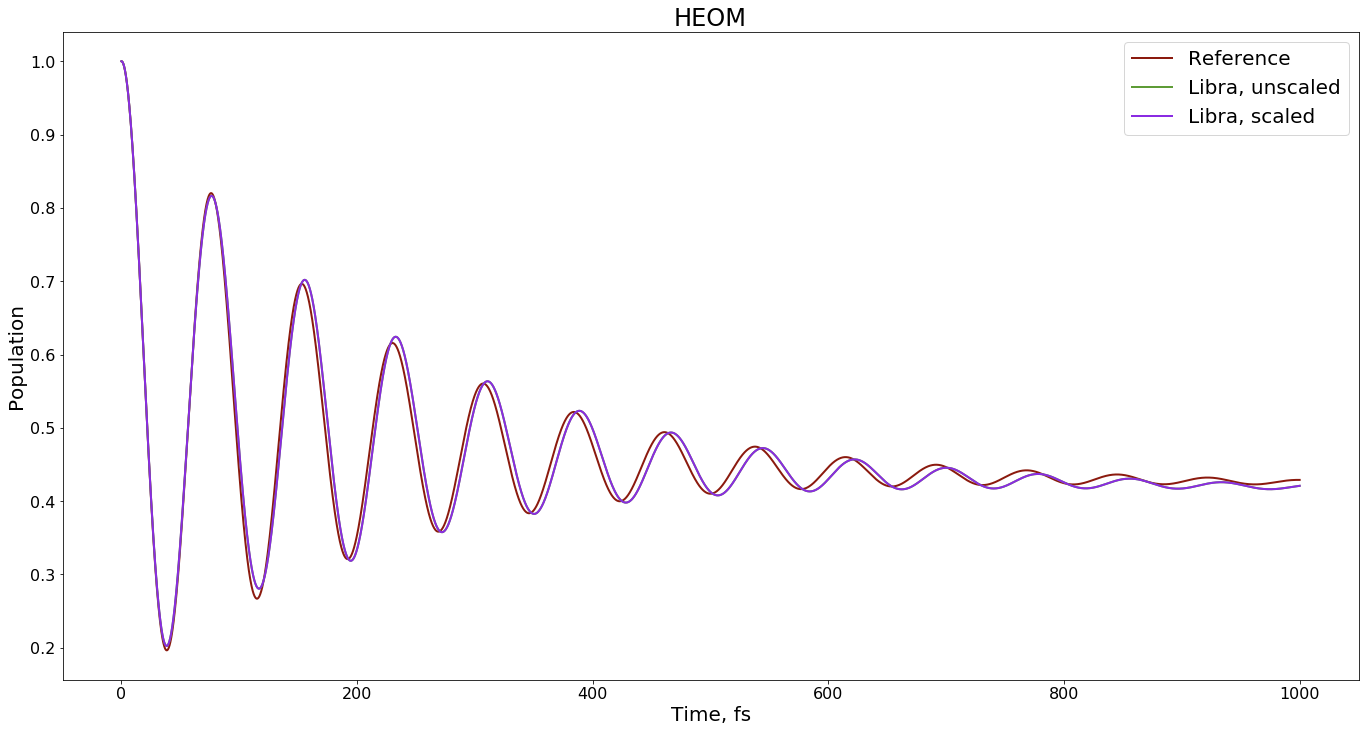

In [10]:
ref = data_read.get_data_from_file2("rho.out", [0, 1, 2] )
lib = [ None, None ]
lib_scaled = [ None, None ]

with h5py.File(F"out/mem_data.hdf", 'r') as f:
    lib[0] = list(f["time/data"][:] * units.au2fs)
    lib[1] = list(f["denmat/data"][:, 0,0])

with h5py.File(F"out_scaled/mem_data.hdf", 'r') as f:
    lib_scaled[0] = list(f["time/data"][:] * units.au2fs)
    lib_scaled[1] = list(f["denmat/data"][:, 0,0])

    
plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('HEOM')
plt.xlabel('Time, fs')
plt.ylabel('Population')
plt.plot(ref[0], ref[1], label='Reference', linewidth=2, color = colors["11"]) 
plt.plot(lib[0], lib[1], label='Libra, unscaled', linewidth=2, color = colors["21"]) 
plt.plot(lib_scaled[0], lib_scaled[1], label='Libra, scaled', linewidth=2, color = colors["31"]) 
plt.legend()
plt.show()
plt.close()
